TBG Model initialized with:
  Twist angle: 0.94°
  Number of Q points: 179
  Hamiltonian size: 358 x 358
  Fermi velocity: 0.6829
  Hopping parameters: u=0.08, u'=0.11

Diagonalizing along K -> Γ -> M -> K' path (with band tracking)...


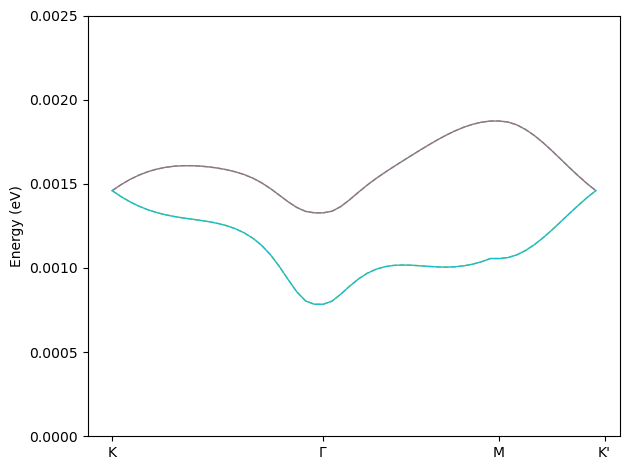

Band structure computed for 56 k-points
Number of bands: 358
Energy range: -1.915 to 1.920 eV


In [3]:
import numpy as np
from numpy.linalg import eigh, norm
import matplotlib.pyplot as plt

def R(x):
    """Generic rotation matrix"""
    return np.array([
        [np.cos(x), -np.sin(x)],
        [np.sin(x),  np.cos(x)]
    ])

# 2x2 Identity matrix
I = np.identity(2)

def Et(theta, theta_s, e, delta):
    """
    A matrix that simultaneously rotates and strains the vector on which it operates.
    See Bi et al., Phys. Rev. B 100, 035448 (2019).
    """
    return R(-theta_s) @ np.array(([e, 0], [0, -delta*e])) @ R(theta_s) + np.array(([0, -theta], [theta, 0]))

# This function recover the reciprocal momentum k=ib[0]+jb[0]-l*q[0];
def recover_ij_from_Q(Q, b, q0, rtol=1e-8, atol=1e-6):
    """
    Given:
      Q : (N,3) array with rows [kx, ky, l] where l in {0,1}
      b : (3,2) array with rows [b1, b2, b3] (we use b1,b2)
      q0: (2,) array equal to q[0]
    Returns:
      ijl : list of tuples (i, j, l) inferred for each row of Q
    """
    B = np.column_stack((b[0], b[1]))  # 2x2 matrix [b1 b2]
    Binv = np.linalg.inv(B)

    ijl = []  ### Indicate List type
    for row in Q:  ## For numpy array, for loop assume the zero-dimension index.
        kx, ky, l = row
        k = np.array([kx, ky], dtype=float)
        l = int(round(l))
        v = Binv @ (k + l * q0)  # continuous (i,j)
        ij = np.rint(v).astype(int)  ## Obtain integer ij 
        k_recon = (B @ ij) - l * q0
        ### Check k_recon
        if not np.allclose(k_recon, k, rtol=rtol, atol=atol):
            raise ValueError(
                f"Could not reliably recover integer (i,j) from Q row {row}. "
                f"Got fractional {v} -> rounded {ij}; recon {k_recon} vs {k}"
            )
        ijl.append((ij[0], ij[1], l))
    return ijl

# For given Q, find all pairs with same layer index
# the pair (199,1) and (1,199) is treated as different.
def find_opposite_G_pairs(Q, b, q, rtol=1e-8, atol=1e-6):
    q0 = q[0]
    ijl = recover_ij_from_Q(Q, b, q0, rtol=rtol, atol=atol)

    buckets = {} ## Define a Dict Object.  
    for idx, (i, j, l) in enumerate(ijl):
        buckets.setdefault((i, j,l), idx);

    pairs = [];
    for (i, j,l), idx_a in buckets.items():
        key_a, key_b = (i, j,l), (-i, -j,l)
        
        if key_b in buckets:
            idx_b = buckets[key_b]
            pairs.append((idx_a, idx_b))

    return pairs

def _perm_from_overlap(U_prev, U_curr):

    O = np.abs(U_prev.conj().T @ U_curr)  # (nband, nband)
    n = O.shape[0]
    perm = [-1]*n
    used_cols = set()
    # Greedy assignment by picking the current largest overlap
    for _ in range(n):
        i, j = divmod(int(O.argmax()), n)
        # find a column not yet used
        while j in used_cols:
            O[i, j] = -1.0
            i, j = divmod(int(O.argmax()), n)
        perm[i] = j
        used_cols.add(j)
        O[i, :] = -1.0
        O[:, j] = -1.0
    return np.array(perm, dtype=int)

class TBGModel():
    def __init__(self, theta, phi, epsilon,  # empirical (deg, deg, strain)
                 a=0.246, beta=3.14, delta=0.16,  # graphene
                 vf=1.3, u=0.08, up=0.11, cut=5):  # continuum
        # Convert degrees to radians
        theta = theta*np.pi/180
        phi = phi*np.pi/180

        # Empirical
        self.theta = theta
        self.phi = phi
        self.epsilon = epsilon

        # Graphene params
        self.a = a
        self.beta = beta
        self.delta = delta
        self.A = np.sqrt(3)*self.beta/2/a  # gauge connection

        # Continuum params
        self.v = vf*2.1354*a      # vf = 1.3 used in many works
        self.v3 = np.sqrt(3)*a*0.32/2
        self.v4 = np.sqrt(3)*a*0.044/2
        self.gamma1 = 0.4
        self.Dp = 0.05

        self.omega = np.exp(1j*2*np.pi/3)
        self.u = u
        self.up = up

        # Monolayer K vectors
        k_d = 4*np.pi/3/a
        k1 = np.array([k_d, 0.0])
        k2 = np.array([np.cos(2*np.pi/3)*k_d, np.sin(2*np.pi/3)*k_d])
        k3 = -np.array([np.cos(np.pi/3)*k_d, np.sin(np.pi/3)*k_d])

        # Strained moiré reciprocal vectors
        q1 = Et(theta, phi, epsilon, delta) @ k1
        q2 = Et(theta, phi, epsilon, delta) @ k2
        q3 = Et(theta, phi, epsilon, delta) @ k3
        q = np.array([q1, q2, q3])
        self.q = q
        k_theta = np.max([norm(q1), norm(q2), norm(q3)])
        self.k_theta = k_theta

        # Q-lattice basis
        b1 = q[1] - q[2]
        b2 = q[0] - q[2]
        b3 = q[1] - q[0]
        b = np.array([b1, b2, b3])
        self.b = b

        # Generate Q lattice
        Q = []
        for i in range(-100, 100):
            for j in range(-100, 100):
                for l in (0, 1):
                    kvec = np.array([i, j, 0.0]) @ b - l*q[0]
                    if norm(kvec) <= np.sqrt(3)*k_theta*cut:
                        Q.append(np.array([kvec[0], kvec[1], l], dtype=float))
        self.Q = np.array(Q, dtype=float)
        self.Nq = len(self.Q)

        # Nearest neighbors on the Q lattice
        self.Q_nn = {}
        Qxy = np.round(self.Q[:, :2], 3)
        Qlist = Qxy.tolist()
        for idx in range(self.Nq):
            nbrs = []
            for j in range(len(q)):
                tgt = np.round(self.Q[idx, :2] + q[j], 3)
                try:
                    jidx = Qlist.index(tgt.tolist())
                    nbrs.append([jidx, j])
                except ValueError:
                    pass
            self.Q_nn[idx] = nbrs

    def find_opposite_G_pairs(self, rtol=1e-8, atol=1e-6):
        return find_opposite_G_pairs(self.Q, self.b, self.q, rtol=rtol, atol=atol)

    def __post_init_deltas(self):
        # Nearest-neighbor A→B real-space vectors (a = lattice constant, 0.246 nm)
        a = self.a
        self.delta_AB = np.array([
            [0.0,          a/np.sqrt(3)],       # δ1
            [-a/2.0,      -a/(2*np.sqrt(3))],   # δ2
            [ a/2.0,      -a/(2*np.sqrt(3))],   # δ3
        ])

    def phi_l(self, q, l, Layer=0, xi=1):

        if not hasattr(self, "delta_AB"):
            self.__post_init_deltas()
        q = np.asarray(q, dtype=float)
        was_1d = (q.ndim == 1)
        q = q.reshape(-1, 2)

        w = self.omega
        l = int(l) % 3
        t = 2*int(Layer) - 1
        M = Et(t*xi*self.theta/2, self.phi, t*xi*self.epsilon/2, self.delta)
        A = np.eye(2) + M

        d1, d2, d3 = (A.T @ self.delta_AB[0],
                      A.T @ self.delta_AB[1],
                      A.T @ self.delta_AB[2])

        val = (np.exp(-1j * (q @ d1)) +
               (w**l)    * np.exp(-1j * (q @ d2)) +
               (w**(2*l))* np.exp(-1j * (q @ d3)))
        return val[0] if was_1d else val

    def gen_ham(self, kx, ky, xi=1):

        k = np.array([kx, ky], dtype=float)

        # Moiré hopping matrices
        U1 = np.array([[self.u, self.up],
                       [self.up, self.u]], dtype=complex)
        U2 = np.array([[self.u, self.up*self.omega**(-xi)],
                       [self.up*self.omega**( xi), self.u]], dtype=complex)
        U3 = np.array([[self.u, self.up*self.omega**( xi)],
                       [self.up*self.omega**(-xi), self.u]], dtype=complex)

        ham = np.zeros((2*self.Nq, 2*self.Nq), dtype=complex)

        for i in range(self.Nq):
            t = self.Q[i, 2]
            l = np.sign(2*t - 1)  # +1 for layer 1, -1 for layer 0
            M = Et(l*xi*self.theta/2, self.phi, l*xi*self.epsilon/2, self.delta)
            E = (M + M.T)/2
            exx, eyy, exy = E[0, 0], E[1, 1], E[0, 1]
            kj = (I + M) @ (k + self.Q[i, :2] + xi*self.A*np.array([exx - eyy, -2*exy]))
            km = xi*kj[0] - 1j*kj[1]

            # Diagonal blocks
            ham[2*i, 2*i+1] = -self.v * km

            # Off-diagonal moiré couplings
            for (j, p) in self.Q_nn[i]:
                ham[2*i:2*i+2, 2*j:2*j+2] = (p == 0)*U1 + (p == 1)*U2 + (p == 2)*U3

        return ham + ham.conj().T

    def _build_kpath(self, res):
        l1 = int(res)                 # K -> Γ
        l2 = int(np.sqrt(3)*res/2)    # Γ -> M
        l3 = int(res/2)               # M -> K'
        kpath = []
        for i in np.linspace(0, 1, l1):
            kpath.append(i*(self.q[0] + self.q[1]))
        for i in np.linspace(0, 1, l2):
            kpath.append(self.q[0] + self.q[1] + i*(-self.q[0]/2 - self.q[1]))
        for i in np.linspace(0, 1, l3):
            kpath.append(self.q[0]/2 + i*self.q[0]/2)
        return np.array(kpath), l1, l2, l3

    def solve_along_path(self, res=24, plot_it=True, return_eigenvectors=False, track_bands=True, ylim=(0.03, 0.06)):
        kpath, l1, l2, l3 = self._build_kpath(res)

        evals_m, evals_p = [], []
        evecs_m, evecs_p = [], []

        U_prev_m = U_prev_p = None
        for kx, ky in kpath:
            val_m, vec_m = eigh(self.gen_ham(kx, ky, +1))
            val_p, vec_p = eigh(self.gen_ham(kx, ky, +1))

            if track_bands and U_prev_m is not None:
                perm_m = _perm_from_overlap(U_prev_m, vec_m)
                val_m = val_m[perm_m]; vec_m = vec_m[:, perm_m]
                perm_p = _perm_from_overlap(U_prev_p, vec_p)
                val_p = val_p[perm_p]; vec_p = vec_p[:, perm_p]

            U_prev_m, U_prev_p = vec_m, vec_p
            evals_m.append(val_m); evals_p.append(val_p)
            if return_eigenvectors:
                evecs_m.append(vec_m); evecs_p.append(vec_p)

        evals_m = np.vstack(evals_m)
        evals_p = np.vstack(evals_p)

        if plot_it:
            plt.figure(1); plt.clf()
            nband = evals_m.shape[1]
            for i in range(nband):
                plt.plot(evals_m[:, i], linestyle='dashed', linewidth=1.0)
                plt.plot(evals_p[:, i], linewidth=1.0)
            if ylim is not None:
                plt.ylim(*ylim)
            plt.xticks([0, l1, l1+l2, l1+l2+l3], ['K', r'$\Gamma$', 'M', "K'"])
            plt.ylabel('Energy (eV)')
            plt.tight_layout()
            plt.show()

        if return_eigenvectors:
            return evals_m, evals_p, np.array(evecs_m), np.array(evecs_p), kpath
        else:
            return evals_m, evals_p, kpath


if __name__ == "__main__":
    magic_angle = 0.94   # degrees
    phi = 0.0            # strain angle
    epsilon = 0.0        # strain magnitude

    tbg = TBGModel(magic_angle, phi, epsilon)

    print(f"TBG Model initialized with:")
    print(f"  Twist angle: {magic_angle}°")
    print(f"  Number of Q points: {tbg.Nq}")
    print(f"  Hamiltonian size: {2*tbg.Nq} x {2*tbg.Nq}")
    print(f"  Fermi velocity: {tbg.v:.4f}")
    print(f"  Hopping parameters: u={tbg.u}, u'={tbg.up}")

    print("\nDiagonalizing along K -> Γ -> M -> K' path (with band tracking)...")
    # Increase res for smoother curves if desired, e.g., res=64 or 96
    evals_m, evals_p, kpath = tbg.solve_along_path(res=24, track_bands=True, ylim=(0.0, 0.0025))

    print(f"Band structure computed for {len(kpath)} k-points")
    print(f"Number of bands: {evals_m.shape[1]}")
    print(f"Energy range: {evals_m.min():.3f} to {evals_m.max():.3f} eV")


In [6]:
import numpy as np
from numpy.linalg import eigh
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
from typing import List, Tuple, Optional


class SmoothTracker:
    
    ## Important. Remember Prevoius State
    def __init__(self, eps_deg: float = 1e-5):
        self.U_prev: Optional[np.ndarray] = None
        self.e_prev: Optional[np.ndarray] = None
        self.eps_deg = eps_deg

    @staticmethod
    def _hungarian_match(U_prev, U_curr):
        O = np.abs(U_prev.conj().T @ U_curr)
        rows, cols = linear_sum_assignment(1.0 - O)
        # linear_sum_assignment minimize the cost function \sum_i 1- O_{i,\pi(i)}
        # So one can find correct cols.
        return cols
    
    
    def _deg_blocks(self, e):
        e = np.asarray(e, float)
        n = e.size
        if n == 0: return []
        blocks = []
        i = 0
        while i < n:
            j = i + 1
            while j < n and abs(e[j] - e[i]) <= self.eps_deg * max(1.0, abs(e[i])):
                j += 1
            blocks.append(np.arange(i, j))
            i = j
        return blocks

    def align(self, e_curr, U_curr):
        #
        if self.U_prev is None:
            e = np.asarray(e_curr).copy()
            U = np.asarray(U_curr, complex).copy()
            ##
            for b in range(U.shape[1]):
                col = U[:, b]
                m = np.argmax(np.abs(col))
                ###
                if np.abs(col[m]) > 0:
                    phase=col[m] / np.abs(col[m]);
                    U[:, b] /= phase;
                ###
            self.e_prev, self.U_prev = e, U
            return e, U

        # 1) match bands
        
        # return permutation index
        perm = self._hungarian_match(self.U_prev, U_curr) 
        e = np.asarray(e_curr)[perm]  ## Perform Permuations.
        U = np.asarray(U_curr, complex)[:, perm]

        # 2) align within degenerate blocks
        for blk in self._deg_blocks(e):
            if np.size(blk) == 1:
                t = int(blk[0])                           # global band index
                ov = self.U_prev[:, t].conj().T @ U[:, t] # complex overlap
                if np.abs(ov) > 0:
                    U[:, t] /= ov / np.abs(ov)            # make overlap real-positive
                continue

            Up = self.U_prev[:, blk]  # (dim, m)
            Uc = U[:, blk]            # (dim, m)
            M = Up.conj().T @ Uc
            L, _, Rh = np.linalg.svd(M, full_matrices=False)
            W = Rh.conj().T @ L.conj().T
            U[:, blk] = Uc @ W
            # parallel-transport (positive-real overlap)
            
            for t in range(len(blk)):
                ov = Up[:, t].conj().T @ U[:, blk[t]]
                if ov != 0:
                    U[:, blk[t]] /= ov/abs(ov)

        self.e_prev, self.U_prev = e, U
        return e, U


def compute_Lambda_smooth(tbg,k,Layer,Sym,pairs,tracker_plus,tracker_minus):
    ##
    k = np.asarray(k, float).reshape(2,)
    kx, ky = k
    #
      
    #The value of COM depends on pairing momentum relative to picked Origin 
    COM=tbg.q[0]+tbg.q[1];    # Here we pick Gamma point
    # 
    H_plus  = np.asarray(tbg.gen_ham(kx+COM[0],  ky+COM[1]))   
    H_minus = np.asarray(tbg.gen_ham(-kx+COM[0], -ky+COM[1]))
    e_plus,  U_plus  = eigh(H_plus)
    e_minus, U_minus = eigh(H_minus)

    # trackers
    if tracker_plus  is None:  tracker_plus  = SmoothTracker()
    if tracker_minus is None:  tracker_minus = SmoothTracker()
    e_plus,  U_plus  = tracker_plus.align(e_plus,  U_plus)
    e_minus, U_minus = tracker_minus.align(e_minus, U_minus)

    M = U_plus.shape[1]

    # pairs on chosen Layer
    
    pairs_L = [(a, b) for (a, b) in pairs
               if int(round(tbg.Q[a, 2])) == Layer and int(round(tbg.Q[b, 2])) == Layer]
    
    # First/Second index of Pair; 
    idx_a = np.fromiter((a for a, _ in pairs_L), dtype=int)
    idx_b = np.fromiter((b for _, b in pairs_L), dtype=int)

    # rows for A/B sublattices

    rows_a = 2*idx_a + 0;
    rows_b = 2*idx_b + 1;  

    V_plus  = np.take(U_plus,  rows_a, axis=0)   # (P, M)
    V_minus = np.take(U_minus, rows_b, axis=0)   # (P, M)

    #  
    q0 = np.asarray(tbg.q[0], float).reshape(2,);    
    Gs = Layer * q0+np.asarray(tbg.Q[idx_a, :2], float) 
    phases = np.conj(np.asarray(tbg.phi_l(Gs + k[None, :], Sym, Layer, xi=1))).reshape(-1)

    P = phases.size
    if V_plus.shape != (P, M) or V_minus.shape != (P, M):
        raise ValueError(
            f"Shape mismatch: phases {phases.shape}, V_plus {V_plus.shape}, V_minus {V_minus.shape}, M {M}"
        )

    #
    Lambda = V_plus.T @ (phases[:, None] * V_minus)
    return Lambda, e_plus, e_minus, tracker_plus, tracker_minus


 
def serpentine_masked_indices(mask):
    H, W = mask.shape
    for i in range(H):
        js = np.flatnonzero(mask[i])
        if i % 2: js = js[::-1]
        for j in js:
            yield i, j

def hex_bz_mesh(b1, b2, N=10,mode ='six'):
    tol=1e-12
    b1 = np.asarray(b1, float); b2 = np.asarray(b2, float)
    B = np.column_stack([b1, b2]); BinvT = np.linalg.inv(B.T)
    b1sq, b2sq = np.dot(b1, b1), np.dot(b2, b2)

    rng = np.arange(-N, N + 1)
    I, J = np.meshgrid(rng, rng, indexing='ij')
    c1 = I / N; c2 = J / N

    if mode == 'six':
        mask = (np.abs(c1) <= 1 + tol) & (np.abs(c2) <= 1 + tol) & (np.abs(c1 + c2) <= 1 + tol)
    elif mode == 'none':
        mask = (np.abs(c1) <  1 - tol) & (np.abs(c2) <  1 - tol) & (np.abs(c1 + c2) <  1 - tol)
    elif mode == 'three_alternating':
        # keep:  c1 = -1, c2 = -1, c1+c2 = +1
        # drop:  c1 = +1, c2 = +1, c1+c2 = -1  (strict)
        mask = (c1 >= -1 - tol) & (c1 <  1 - tol) & \
               (c2 >= -1 - tol) & (c2 <  1 - tol) & \
               (c1 + c2 <= 1 + tol) & (c1 + c2 > -1 + tol)
        # => all 6 vertices are excluded (each sits on one dropped edge)
    elif mode == 'three_consecutive':
        # keep:  c1 = -1, c2 = -1, c1+c2 = -1  (inclusive)
        # drop:  c1 = +1, c2 = +1, c1+c2 = +1  (strict)
        mask = (c1 >= -1 - tol) & (c2 >= -1 - tol) & (c1 + c2 >= -1 - tol) & \
               (c1 <  1 - tol) & (c2 <  1 - tol) & (c1 + c2 <  1 - tol)
        # => includes exactly two vertices: (-1,0) and (0,-1)
    else:
        raise ValueError("mode must be 'six', 'none', 'three_alternating', or 'three_consecutive'")

    c1v = c1[mask].ravel()
    c2v = c2[mask].ravel()
    s = np.vstack([0.5 * b1sq * c1v, 0.5 * b2sq * c2v])  # [k·b1, k·b2]
    kpts = (BinvT @ s).T
    idx_map = -np.ones(mask.shape, dtype=int)
    idx_map[mask] = np.arange(mask.sum(), dtype=int)
    return kpts, mask, idx_map

import os
import numpy as np
from numpy.linalg import norm, eigh

#
OUT_DIR = "lambda_dump"
 
# 
def ensure_dir(path):
    if not os.path.isdir(path):
        os.makedirs(path, exist_ok=True)

def save_lambda_npz(basepath, k, layer, sym, Lambda, evals_plus, evals_minus):
    np.savez_compressed(basepath + ".npz",k=np.asarray(k, float),
        layer=int(layer),sym=int(sym),Lambda=Lambda,
        evals_plus=np.asarray(evals_plus, float),
        evals_minus=np.asarray(evals_minus, float),
    )

def save_lambda_csv_pair(basepath, Lambda):
    # CSVs for real/imag separately (compact and easy to reload)
    np.savetxt(basepath + "_real.csv", np.real(Lambda), delimiter=",")
    np.savetxt(basepath + "_imag.csv", np.imag(Lambda), delimiter=",")

def dump_all_Lambdas_smooth(tbg,b1,b2,N1,*,out_dir=OUT_DIR,eps_deg=1e-5):
    
    #
    ensure_dir(out_dir)
    pairs = tbg.find_opposite_G_pairs()
    Gamma=tbg.q[0]+tbg.q[1]; 
    # fix a smooth order
    kpts_cart, mask, idx_map=hex_bz_mesh(b1, b2, N1,mode = 'six')
    order = [idx_map[i, j] for i, j in serpentine_masked_indices(mask)]

    # write index of k points
    index_path = os.path.join(out_dir, "k_index.csv")
    with open(index_path, "w") as fidx:
        fidx.write("k_index,kx,ky\n")
        for new_i, flat_i in enumerate(order):
            k = kpts_cart[flat_i]
            fidx.write(f"{new_i},{k[0]},{k[1]}\n")


    summary_path = os.path.join(out_dir, "summary.csv")
    with open(summary_path, "w") as fs:
        fs.write("k_index,layer,sym,M,trace_abs,max_abs\n")

        trackers = {}
        for layer in (0, 1):
            for sym in (0,2):
                trackers[(layer, sym)] = (SmoothTracker(eps_deg=eps_deg),
                                          SmoothTracker(eps_deg=eps_deg))

        
        for new_i, flat_i in enumerate(order):
            k = np.asarray(kpts_cart[flat_i], float).reshape(2,)
            #Compute 
            for layer in (0, 1):
                for sym in (0,2):
                    
                    tr_p, tr_m = trackers[(layer, sym)]
                    #  
                    Lambda, evals_plus, evals_minus, tr_p, tr_m = compute_Lambda_smooth(
                        tbg, k,Layer=layer,Sym=sym,pairs=pairs,
                        tracker_plus=tr_p,tracker_minus=tr_m,
                    )
                    # persist updated trackers
                    trackers[(layer, sym)] = (tr_p, tr_m)
                    ##
                    M = Lambda.shape[0]
                    base = os.path.join(out_dir, f"k{new_i:05d}_L{layer}_S{sym}")

                    # compact binary (recommended)
                    save_lambda_npz(base, k, layer, sym, Lambda, evals_plus, evals_minus)


                    # quick metrics
                    fs.write("{},{},{},{},{:.6e},{:.6e}\n".format(
                        new_i, layer, sym, M,
                        float(np.abs(np.trace(Lambda))),
                        float(np.max(np.abs(Lambda)))
                    ))

 

b1 = tbg.q[0] - tbg.q[1]
b2 = tbg.q[2] - tbg.q[0]
N1=21;
 
# Use serpentine traversal for smoother tracking across the mesh
dump_all_Lambdas_smooth(
    tbg, b1, b2, N1,
    out_dir="lambda_dump",
    eps_deg=1e-5)

print("Done. Files in ./lambda_dump")

Done. Files in ./lambda_dump
